# Practico 2 - Redes Bayesianas y Estimación de distribuciones continuas.

El objetivo de esta notebook es implementar las redes bayesianas sobre el dataset de Tennis y continuar explorando formas de estimar distribuciones pero esta vez sobre datos continuos. 

## Parte 1: Redes Bayesianas

## Imports

In [1]:
#!pip install pgmpy

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from scipy.stats import norm

c:\Users\joaco\anaconda3\envs\ml-para-ia\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Paso 1: Cargar los Datos y Construir el Modelo

In [3]:
# Cargar los datos
data = pd.read_csv('./tennis.csv')
data.head()

,Day,Outlook,Temp,Humidity,Wind,Tennis
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,High,Strong,No
2,D3,Overcast,Hot,High,Weak,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes


Definimos variables aleatorias que vamos a usar. Por simplicidad en la visualización solo usaremos 3, pero puede usar todas las que quiera.

In [4]:
outlook = 'Outlook'
temp = 'Temp'
wind = 'Wind'
tennis = 'Tennis'

data = data[[outlook, temp, tennis]]

Tenemos que definir las relaciones condicionales que hay entre estas variables, para eso vamos a definir las siguientes relaciones: 

- Tennis depende de Outlook
- Tennis depende de Temp

In [5]:
relations = [(outlook, tennis), (temp, tennis)]

Teniendo las relaciones vamos a crear nuestro modelo!

In [6]:
model = DiscreteBayesianNetwork (relations)

Ahora que tenemos el modelo vamos a ajustarlo para que capture las probabilidades condicionales en las observaciones.

In [7]:
# Aprender los CPDs desde los datos
model.fit(data, estimator=MaximumLikelihoodEstimator)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Outlook': 'C', 'Temp': 'C', 'Tennis': 'C'}


Verificamos si el modelo es valido.

In [8]:
model.check_model()

True

### Paso 2: Visualización del Grafo y CPDs

In [9]:
def visualize_graph(model):
    G = nx.DiGraph()
    G.add_edges_from(model.edges())
    plt.figure(figsize=(7, 5))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=10000, node_color="skyblue", font_size=14, font_weight="bold", arrowsize=30)
    plt.title("Red Bayesiana del Dataset de Tenis")
    plt.show()

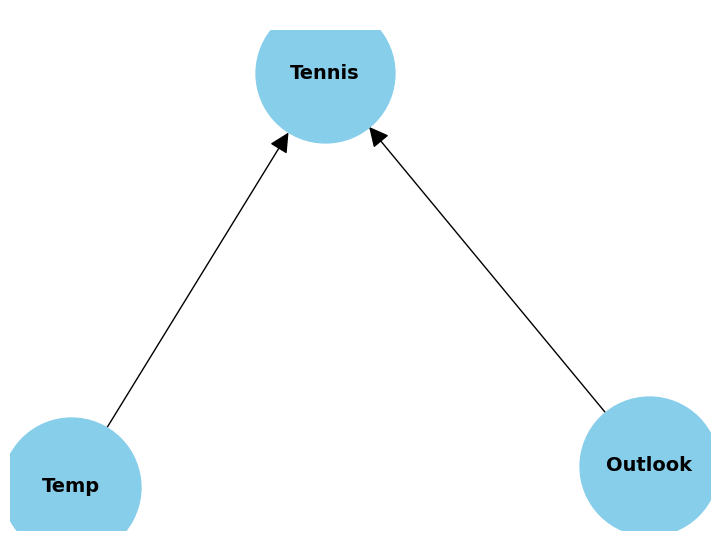

In [10]:
visualize_graph(model)

In [11]:
for cpd in model.get_cpds():
    print(f"CPD de {cpd.variable}:")
    print(cpd)

CPD de Outlook:
+-------------------+----------+
| Outlook(Overcast) | 0.285714 |
+-------------------+----------+
| Outlook(Rain)     | 0.357143 |
+-------------------+----------+
| Outlook(Sunny)    | 0.357143 |
+-------------------+----------+
CPD de Tennis:
+-------------+-------------------+-----+----------------+----------------+
| Outlook     | Outlook(Overcast) | ... | Outlook(Sunny) | Outlook(Sunny) |
+-------------+-------------------+-----+----------------+----------------+
| Temp        | Temp(Cool)        | ... | Temp(Hot)      | Temp(Mild)     |
+-------------+-------------------+-----+----------------+----------------+
| Tennis(No)  | 0.0               | ... | 1.0            | 0.5            |
+-------------+-------------------+-----+----------------+----------------+
| Tennis(Yes) | 1.0               | ... | 0.0            | 0.5            |
+-------------+-------------------+-----+----------------+----------------+
CPD de Temp:
+------------+----------+
| Temp(Cool) | 

### Explicación:
- **Estructura de la Red:** Los arcos en la red representan la relación de causa y efecto entre las variables. Aquí, las condiciones del clima influyen en la decisión de jugar tenis.
- **CPDs:** Cada nodo tiene un CPD que describe la distribución de probabilidad condicional de la variable dada sus padres.

¿Por qué la tabla de Outlook y Temp solamente una columna mientras que la de Tennis tiene varias?

    La de outlook tiene una sola columna porque no depende de ninguna otra variable aleatoria segun la red bayesiana definida, mientras que Tennis depende de Temp y de Overcast

¿Cuántas columnas tiene la de Tennis? ¿Por qué?

    La de Tennis tiene 9 columnas, porque son las combinaciones posibles entre Temp y Outlook

In [12]:
for cpd in model.get_cpds():
    print(f"Variable: {cpd.variable}")
    print("  Estados:")
    for state in cpd.state_names[cpd.variable]:
        print(f"    - {state}")
    print(f"  Cardinalidad: {cpd.variable_card}\n")

Variable: Outlook
  Estados:
    - Overcast
    - Rain
    - Sunny
  Cardinalidad: 3

Variable: Tennis
  Estados:
    - No
    - Yes
  Cardinalidad: 2

Variable: Temp
  Estados:
    - Cool
    - Hot
    - Mild
  Cardinalidad: 3



- **Cardinalidad:** Indica cuántos estados puede tener una variable.

### Paso 3: Inferencia en la Red

**Inferencia:** Dado un conjunto de evidencias (ej. Outlook y Temp), la red calcula la probabilidad de que Tennis sea 'Yes' o 'No'.

In [13]:
# Inferencia en la red bayesiana
inferencia = VariableElimination(model)
resultado = inferencia.query(variables=[tennis], evidence={outlook: 'Sunny', temp: 'Mild'})
print("\nResultado de la inferencia:")
print(resultado)


Resultado de la inferencia:
+-------------+---------------+
| Tennis      |   phi(Tennis) |
+=============+===============+
| Tennis(No)  |        0.5000 |
+-------------+---------------+
| Tennis(Yes) |        0.5000 |
+-------------+---------------+


### Ejercicios:
1. Realice inferencias usando diferentes combinaciones de evidencias para observar cómo cambian las probabilidades.
2. Cree otro modelo con diferentes relaciones y realice inferencias sobre este.
 Recuerde que puede agregar más variables (como por ej. Humudity o Wind).

1.

In [14]:
# Inferencia en la red bayesiana
inferencia = VariableElimination(model)
resultado = inferencia.query(variables=[tennis], evidence={outlook: 'Overcast', temp: 'Hot'})
print("\nResultado de la inferencia:")
print(resultado)


Resultado de la inferencia:
+-------------+---------------+
| Tennis      |   phi(Tennis) |
+=============+===============+
| Tennis(No)  |        0.0000 |
+-------------+---------------+
| Tennis(Yes) |        1.0000 |
+-------------+---------------+


In [15]:
# Inferencia en la red bayesiana
inferencia = VariableElimination(model)
resultado = inferencia.query(variables=[tennis], evidence={outlook: 'Rain', temp: 'Cool'})
print("\nResultado de la inferencia:")
print(resultado)


Resultado de la inferencia:
+-------------+---------------+
| Tennis      |   phi(Tennis) |
+=============+===============+
| Tennis(No)  |        0.5000 |
+-------------+---------------+
| Tennis(Yes) |        0.5000 |
+-------------+---------------+


In [16]:
# Inferencia en la red bayesiana
inferencia = VariableElimination(model)
resultado = inferencia.query(variables=[tennis], evidence={outlook: 'Rain', temp: 'Hot'})
print("\nResultado de la inferencia:")
print(resultado)


Resultado de la inferencia:
+-------------+---------------+
| Tennis      |   phi(Tennis) |
+=============+===============+
| Tennis(No)  |        0.5000 |
+-------------+---------------+
| Tennis(Yes) |        0.5000 |
+-------------+---------------+


2.

In [17]:
# Cargar los datos
data = pd.read_csv('./tennis.csv')
data.head()

,Day,Outlook,Temp,Humidity,Wind,Tennis
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,High,Strong,No
2,D3,Overcast,Hot,High,Weak,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes


In [25]:
outlook = 'Outlook'
temp = 'Temp'
wind = 'Wind'
tennis = 'Tennis'
humidity = 'Humidity'

data = data[[outlook, temp, tennis, wind, humidity]]

In [26]:
relations_2 = [(humidity,outlook),(temp,outlook),(wind,humidity),(outlook,tennis)]

In [27]:
model_2 = DiscreteBayesianNetwork (relations_2)

In [28]:
model_2.fit(data, estimator=MaximumLikelihoodEstimator)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Outlook': 'C', 'Temp': 'C', 'Tennis': 'C', 'Wind': 'C', 'Humidity': 'C'}


In [29]:
model_2.check_model()

True

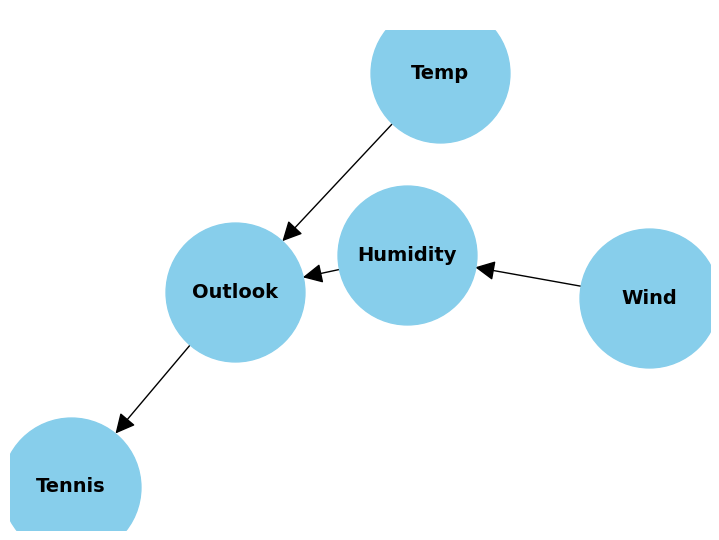

In [30]:
visualize_graph(model_2)

In [32]:
# Inferencia en la red bayesiana
inferencia = VariableElimination(model_2)
resultado = inferencia.query(variables=[tennis], evidence={outlook: 'Sunny', temp: 'Mild', humidity: 'High', wind: 'Weak'})
print("\nResultado de la inferencia:")
print(resultado)


Resultado de la inferencia:
+-------------+---------------+
| Tennis      |   phi(Tennis) |
+=============+===============+
| Tennis(No)  |        0.6000 |
+-------------+---------------+
| Tennis(Yes) |        0.4000 |
+-------------+---------------+


In [33]:
# Inferencia en la red bayesiana
inferencia = VariableElimination(model_2)
resultado = inferencia.query(variables=[tennis], evidence={outlook:'Rain'})
print("\nResultado de la inferencia:")
print(resultado)


Resultado de la inferencia:
+-------------+---------------+
| Tennis      |   phi(Tennis) |
+=============+===============+
| Tennis(No)  |        0.4000 |
+-------------+---------------+
| Tennis(Yes) |        0.6000 |
+-------------+---------------+


## Parte 2: Estimando distribuciones continuas.

El objetivo de esta notebook es explorar una primera manera de aproximar $p(x|y)$ y $p(y|x)$ en un dataset tabular donde $x\in\mathbb{R}^k$ y el objetivo $y$ es una variable discreta y finita $y\in\{0,\ldots,d\}⊆\mathbb{N}, d\geq 1$.

### Imports

In [34]:
import numpy as np
import seaborn as sns

from sklearn import datasets
from matplotlib import pyplot as plt

### Cargamos el dataset

In [35]:
iris = datasets.load_iris()

In [36]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [37]:
X = iris.data
y = iris.target

In [38]:
iris_df = pd.DataFrame(data=X,
             columns=iris.feature_names,
             )

iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


Para simplificar el problema solo trabajaremos con una variable aleatoria.

Filtramos el dataset por feature.

feature_number puede ser 0, 1, 2, 3
- 0 - sepal length (cm)
- 1 - sepal width (cm)
- 2 - petal length (cm)
- 3 - petal width (cm)

In [39]:
feature_number = 0
feature_name = iris.feature_names[feature_number]
xfeature_original = X[:,feature_number]
xfeature_original

array([5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8,
       4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5. ,
       5. , 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5. , 5.5, 4.9, 4.4,
       5.1, 5. , 4.5, 4.4, 5. , 5.1, 4.8, 5.1, 4.6, 5.3, 5. , 7. , 6.4,
       6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5. , 5.9, 6. , 6.1, 5.6,
       6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7,
       6. , 5.7, 5.5, 5.5, 5.8, 6. , 5.4, 6. , 6.7, 6.3, 5.6, 5.5, 5.5,
       6.1, 5.8, 5. , 5.6, 5.7, 5.7, 6.2, 5.1, 5.7, 6.3, 5.8, 7.1, 6.3,
       6.5, 7.6, 4.9, 7.3, 6.7, 7.2, 6.5, 6.4, 6.8, 5.7, 5.8, 6.4, 6.5,
       7.7, 7.7, 6. , 6.9, 5.6, 7.7, 6.3, 6.7, 7.2, 6.2, 6.1, 6.4, 7.2,
       7.4, 7.9, 6.4, 6.3, 6.1, 7.7, 6.3, 6.4, 6. , 6.9, 6.7, 6.9, 5.8,
       6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9])

Como estamos trabajando con valores continuos, vamos a discretizarlos.

Para ello, vamos a utilizar la funcion linspace de numpy, que nos permite dividir un rango en n partes iguales. https://numpy.org/doc/stable/reference/generated/numpy.linspace.html

Hacemos el siguiente calculo para tener la cantidad de bins que deseamos ya que la librería siempre nos crea uno más.

In [40]:
NBINS = 10
bin_size = (np.max(xfeature_original) - np.min(xfeature_original)) / NBINS
end = np.max(xfeature_original) - bin_size
bins = np.linspace(start=np.min(xfeature_original), stop=end, num=NBINS)

bins

array([4.3 , 4.66, 5.02, 5.38, 5.74, 6.1 , 6.46, 6.82, 7.18, 7.54])

In [41]:
xfeature_digitized = np.digitize(x=xfeature_original, bins=bins)
xfeature_digitized

array([ 3,  2,  2,  1,  2,  4,  1,  2,  1,  2,  4,  2,  2,  1,  5,  4,  4,
        3,  4,  3,  4,  3,  1,  3,  2,  2,  2,  3,  3,  2,  2,  4,  3,  4,
        2,  2,  4,  2,  1,  3,  2,  1,  1,  2,  3,  2,  3,  1,  3,  2,  8,
        6,  8,  4,  7,  4,  6,  2,  7,  3,  2,  5,  5,  6,  4,  7,  4,  5,
        6,  4,  5,  6,  6,  6,  6,  7,  7,  7,  5,  4,  4,  4,  5,  5,  4,
        5,  7,  6,  4,  4,  4,  6,  5,  2,  4,  4,  4,  6,  3,  4,  6,  5,
        8,  6,  7, 10,  2,  9,  7,  9,  7,  6,  7,  4,  5,  6,  7, 10, 10,
        5,  8,  4, 10,  6,  7,  9,  6,  6,  6,  9,  9, 10,  6,  6,  6, 10,
        6,  6,  5,  8,  7,  8,  5,  7,  7,  7,  6,  7,  6,  5])

### Aproximamos $p(x|y)$

Para calcular la distribución $p (x | y)$ usamos *distplot kde* (Kernel Density Estimation) para cada clase con los datos originales (datos continuos y no los discretizados).

Para este paso aprovechamos que el dataset esta ordenado por clase.

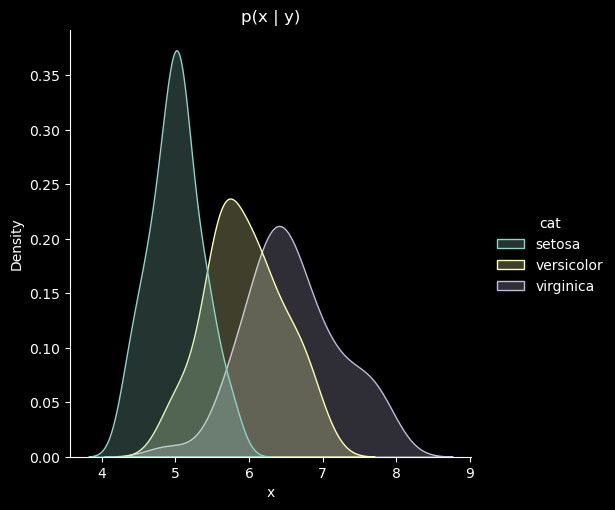

In [42]:
pd_cats = pd.DataFrame(xfeature_original.flatten(), columns=['x'])
pd_cats['cat'] = np.concatenate((np.full(50, 'setosa'),
                                np.full(50, 'versicolor'),
                                np.full(50, 'virginica')))
sns.displot(
    data=pd_cats, x='x', kind='kde',
    hue='cat', fill=True
)

plt.title('p(x | y)')
plt.show()

¿Qué nos muestra esta gráfica?

    La gráfica nos muestra que los datos se distribuyen normalmente segun el largo del sepalo. Para cada variedad de flor.

¿Qué conclusiones puede sacar?

    Se puede visualizar que las flores de clase "setosa" son las que  tienen en promedio un largo de sepalo menor, seguidas de las "versicolor", y las "virginica" son las que presentan un largo de sepalo mayor. 

Ejercicio: Grafique un histograma para cada clase que nos muestre $p (bin| y = clase)$ utilizando los datos discretizados. Puede utilizar la función *np.histogram*. https://numpy.org/doc/stable/reference/generated/numpy.histogram.html

Luego compare los histogramas con la gráfica de arriba sobre $p (x | y)$.

In [43]:
xfeature_digitized

array([ 3,  2,  2,  1,  2,  4,  1,  2,  1,  2,  4,  2,  2,  1,  5,  4,  4,
        3,  4,  3,  4,  3,  1,  3,  2,  2,  2,  3,  3,  2,  2,  4,  3,  4,
        2,  2,  4,  2,  1,  3,  2,  1,  1,  2,  3,  2,  3,  1,  3,  2,  8,
        6,  8,  4,  7,  4,  6,  2,  7,  3,  2,  5,  5,  6,  4,  7,  4,  5,
        6,  4,  5,  6,  6,  6,  6,  7,  7,  7,  5,  4,  4,  4,  5,  5,  4,
        5,  7,  6,  4,  4,  4,  6,  5,  2,  4,  4,  4,  6,  3,  4,  6,  5,
        8,  6,  7, 10,  2,  9,  7,  9,  7,  6,  7,  4,  5,  6,  7, 10, 10,
        5,  8,  4, 10,  6,  7,  9,  6,  6,  6,  9,  9, 10,  6,  6,  6, 10,
        6,  6,  5,  8,  7,  8,  5,  7,  7,  7,  6,  7,  6,  5])

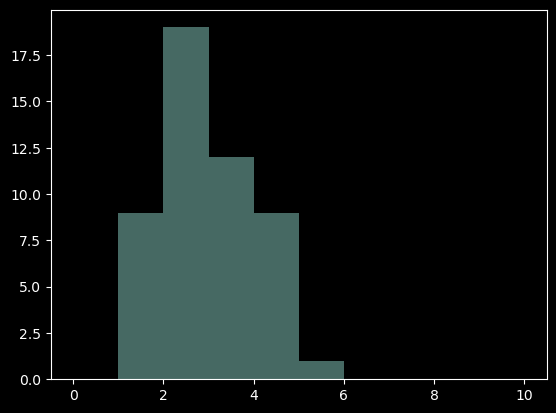

In [44]:
plt.hist(xfeature_digitized[np.where(pd_cats['cat']=='setosa')], bins=[0,1,2,3,4,5,6,7,8,9,10], alpha=0.5, label='setosa')
plt.show()

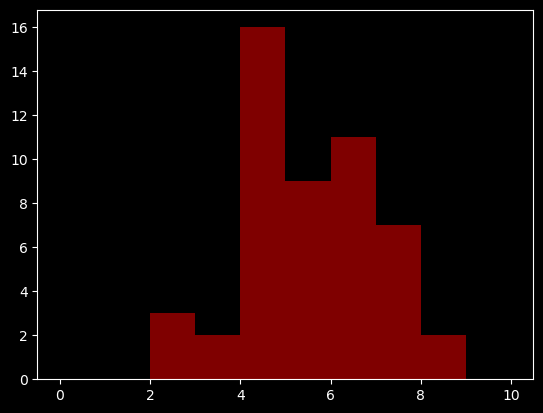

In [45]:
plt.hist(xfeature_digitized[np.where(pd_cats['cat']=='versicolor')], bins=[0,1,2,3,4,5,6,7,8,9,10], alpha=0.5, label='versicolor',color='red')
plt.show()

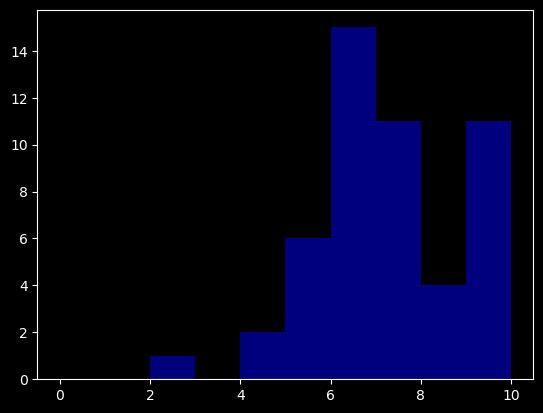

In [46]:
plt.hist(xfeature_digitized[np.where(pd_cats['cat']=='virginica')], bins=[0,1,2,3,4,5,6,7,8,9,10], alpha=0.5, label='virginica',color='blue')
plt.show()

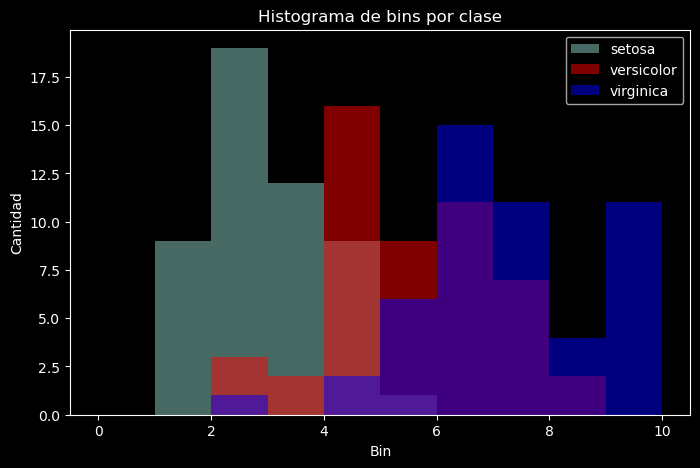

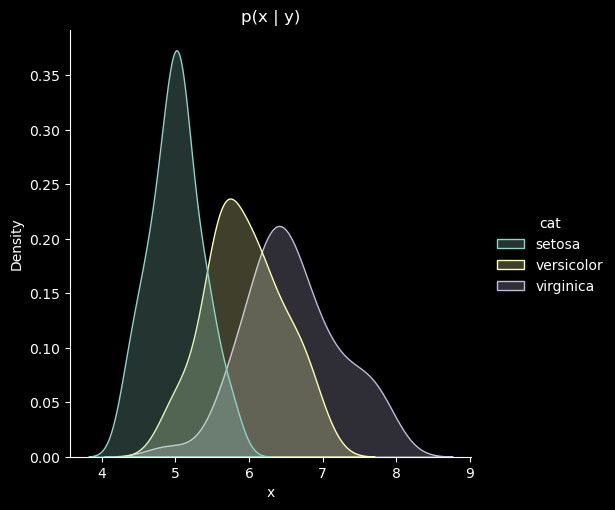

In [47]:
plt.figure(figsize=(8, 5))
plt.hist(xfeature_digitized[np.where(pd_cats['cat']=='setosa')], bins=np.arange(NBINS+1), alpha=0.5, label='setosa')
plt.hist(xfeature_digitized[np.where(pd_cats['cat']=='versicolor')], bins=np.arange(NBINS+1), alpha=0.5, label='versicolor', color='red')
plt.hist(xfeature_digitized[np.where(pd_cats['cat']=='virginica')], bins=np.arange(NBINS+1), alpha=0.5, label='virginica', color='blue')
plt.xlabel('Bin')
plt.ylabel('Cantidad')
plt.legend()
plt.title('Histograma de bins por clase')

# Gráfico de KDE al costado
sns.displot(
    data=pd_cats, x='x', kind='kde',
    hue='cat', fill=True
)
plt.title('p(x | y)')
plt.show()

Observamos al comparar los gráficos que la conclusión comentada anteriormente se mantiene, las setosas son las que tienen en promedio un menor largo de sepalo seguidas por las versicolor.

### Aproximamos $p(y|x)$

Estime la probabilidad condicional de *y* dado *x* y luego muestree 10 valores de y dado que $x = 4.75$

In [48]:
pd_cats

,x,cat
0,5.1,setosa
1,4.9,setosa
2,4.7,setosa
3,4.6,setosa
4,5.0,setosa
...,...,...
145,6.7,virginica
146,6.3,virginica
147,6.5,virginica
148,6.2,virginica


In [49]:
xfeature_original

array([5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8,
       4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5. ,
       5. , 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5. , 5.5, 4.9, 4.4,
       5.1, 5. , 4.5, 4.4, 5. , 5.1, 4.8, 5.1, 4.6, 5.3, 5. , 7. , 6.4,
       6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5. , 5.9, 6. , 6.1, 5.6,
       6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7,
       6. , 5.7, 5.5, 5.5, 5.8, 6. , 5.4, 6. , 6.7, 6.3, 5.6, 5.5, 5.5,
       6.1, 5.8, 5. , 5.6, 5.7, 5.7, 6.2, 5.1, 5.7, 6.3, 5.8, 7.1, 6.3,
       6.5, 7.6, 4.9, 7.3, 6.7, 7.2, 6.5, 6.4, 6.8, 5.7, 5.8, 6.4, 6.5,
       7.7, 7.7, 6. , 6.9, 5.6, 7.7, 6.3, 6.7, 7.2, 6.2, 6.1, 6.4, 7.2,
       7.4, 7.9, 6.4, 6.3, 6.1, 7.7, 6.3, 6.4, 6. , 6.9, 6.7, 6.9, 5.8,
       6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9])

In [50]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [51]:
from scipy.stats import gaussian_kde

In [52]:
classes = [0, 1, 2]
class_names = iris.target_names
features_by_class = [
    xfeature_original[y == c] for c in classes
]
kdes = [gaussian_kde(feat) for feat in features_by_class]

In [53]:
# 2. Calcular p(y) como frecuencia relativa
py = np.array([np.mean(y == c) for c in classes])

In [54]:
# 3. Evaluar p(x=4.75|y) para cada clase
x_value = 4.75
px_given_y = np.array([kde.evaluate(x_value)[0] for kde in kdes])

# 4. Multiplicar por p(y) y normalizar
unnormalized = px_given_y * py
py_given_x = unnormalized / np.sum(unnormalized)

# 5. Mostrar las probabilidades
for i, prob in enumerate(py_given_x):
    print(f"p(y={class_names[i]} | x={x_value:.2f}) = {prob:.4f}")

# 6. Muestrear 10 valores de y según la distribución obtenida
samples = np.random.choice(class_names, size=10, p=py_given_x)
print("\nMuestra de 10 valores de y dado x=4.75:")
print(samples)


p(y=setosa | x=4.75) = 0.8761
p(y=versicolor | x=4.75) = 0.0960
p(y=virginica | x=4.75) = 0.0278

Muestra de 10 valores de y dado x=4.75:
['setosa' 'setosa' 'setosa' 'setosa' 'versicolor' 'setosa' 'setosa'
 'setosa' 'setosa' 'setosa']


### Sampleamos sobre *p(x|y)*

Realice una muestra de 50 valores de $x$ para cada valor de $y$. Recomendamos utilizar la función *gaussian_kde* de *scipy.stats*.

In [64]:
from scipy.stats import gaussian_kde
muestras = [kde.resample(size=50) for kde in kdes]

In [56]:
muestras

[array([[4.86007504, 5.4271016 , 4.96749229, 5.20771893, 4.70221183,
         5.29979376, 5.13946679, 4.80555543, 4.62135417, 4.7692927 ,
         5.04861914, 4.8020904 , 5.25567706, 5.23737333, 5.36305894,
         5.66673701, 4.79301013, 4.60787123, 4.61198857, 4.6063186 ,
         4.94142278, 4.80213369, 4.94100026, 5.02459882, 5.18006878,
         4.96564928, 4.88811538, 4.66041227, 4.89540182, 5.78075869,
         4.73074621, 4.39185226, 5.58284804, 5.20583363, 5.90697783,
         5.18505333, 4.43695605, 4.44849436, 4.60035213, 5.01720861,
         5.9272194 , 5.2451963 , 4.86486295, 5.23008844, 4.44829341,
         4.93859112, 5.20241811, 5.4532157 , 5.12421138, 4.30725621]]),
 array([[5.35355676, 5.4136816 , 5.46143634, 6.02428782, 6.88010046,
         5.07484097, 7.10315299, 5.38165782, 5.78925278, 5.29708807,
         6.91088949, 5.1474894 , 4.86585716, 5.57347421, 5.99770047,
         6.82026728, 6.07534161, 7.13831926, 4.73617526, 5.81533699,
         5.76750141, 5.03788781

Grafique $p(x|y)$ utilizando los datos sampleados y compare con la gráfica de $p(x|y)$ creada con los datos originales.

C:\Users\joaco\AppData\Local\Temp\ipykernel_23336\2890331181.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 800x500 with 0 Axes>

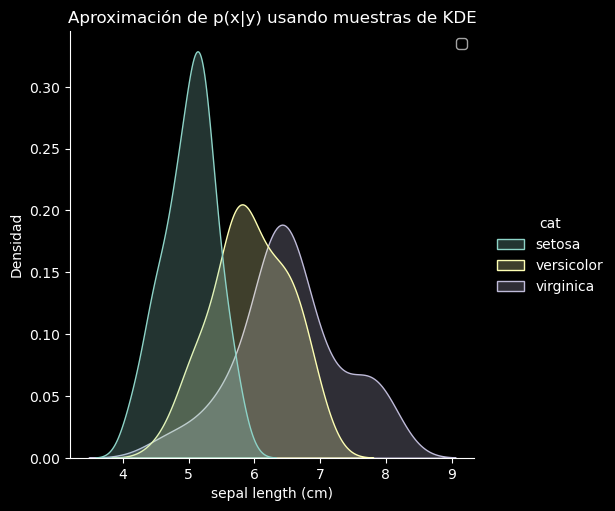

In [65]:
plt.figure(figsize=(8, 5))
sample_df = pd.DataFrame({
    'x': np.concatenate([sample.flatten() for sample in muestras]),
    'cat': np.repeat(class_names, [sample.size for sample in muestras])
})
sns.displot(
    data=sample_df, x='x', kind='kde',
    hue='cat', fill=True
)
plt.xlabel('sepal length (cm)')
plt.ylabel('Densidad')
plt.legend()
plt.title('Aproximación de p(x|y) usando muestras de KDE')
plt.show()

### Aproximamos la distribución normal de $p(x|y)$

In [58]:
# Separamos los datos de cada clase
setosa_feature = xfeature_original[:50]
versicolor_feature = xfeature_original[51:100]
virginica_feature = xfeature_original[101:150]

Calcule la media y la desviación estándar para cada valor de $y$.

In [66]:
media_setosa = np.mean(setosa_feature)
media_versicolor = np.mean(versicolor_feature)
media_virginica = np.mean(virginica_feature)

desv_estandar_setosa = np.std(setosa_feature)
desv_estandar_versicolor = np.std(versicolor_feature)
desv_estandar_virginica = np.std(virginica_feature)

print(f'Media Setosa: {media_setosa}')
print(f'Media Versicolor: {media_versicolor}')
print(f'Media Virginica: {media_virginica}')

print(f'Desviación Estándar Setosa: {desv_estandar_setosa}')
print(f'Desviación Estándar Versicolor: {desv_estandar_versicolor}')
print(f'Desviación Estándar Virginica: {desv_estandar_virginica}')

Media Setosa: 5.006
Media Versicolor: 5.914285714285715
Media Virginica: 6.593877551020409
Desviación Estándar Setosa: 0.3489469873777391
Desviación Estándar Versicolor: 0.4928053803045812
Desviación Estándar Virginica: 0.634519957797217


Utilice la función *normal* de *np.random* para realizar una muestra sobre cada distribución normal.

In [69]:
# Muestra de 50 valores de x para cada clase usando la distribución normal estimada
np.random.seed(42)  # Para reproducibilidad

In [68]:
setosa_samples = np.random.normal(loc=media_setosa, scale=desv_estandar_setosa, size=50)
versicolor_samples = np.random.normal(loc=media_versicolor, scale=desv_estandar_versicolor, size=50)
virginica_samples = np.random.normal(loc=media_virginica, scale=desv_estandar_virginica, size=50)

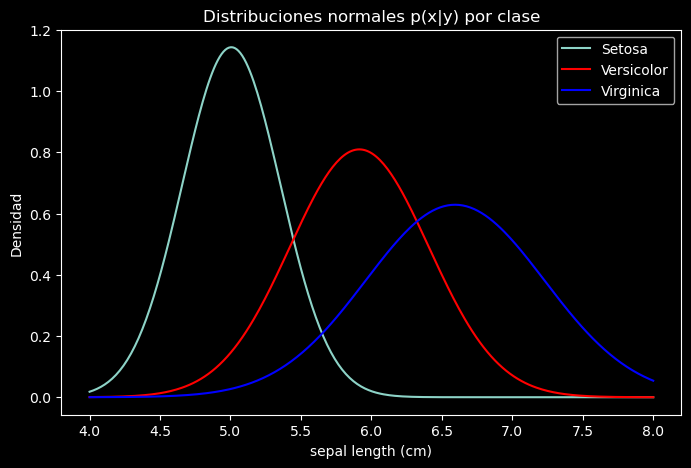

In [70]:
# Crear eje x para graficar
x = np.linspace(4, 8, 300)

# Distribuciones normales para cada clase
pdf_setosa = norm.pdf(x, loc=media_setosa, scale=desv_estandar_setosa)
pdf_versicolor = norm.pdf(x, loc=media_versicolor, scale=desv_estandar_versicolor)
pdf_virginica = norm.pdf(x, loc=media_virginica, scale=desv_estandar_virginica)

plt.figure(figsize=(8, 5))
plt.plot(x, pdf_setosa, label='Setosa')
plt.plot(x, pdf_versicolor, label='Versicolor', color='red')
plt.plot(x, pdf_virginica, label='Virginica', color='blue')
plt.xlabel('sepal length (cm)')
plt.ylabel('Densidad')
plt.title('Distribuciones normales p(x|y) por clase')
plt.legend()
plt.show()

Compare esta gráfica con la gráfica de *p(x|y)* original.

### Graficamos la mezcla de Gaussianas.

Grafique la mezcla de Gaussianas.

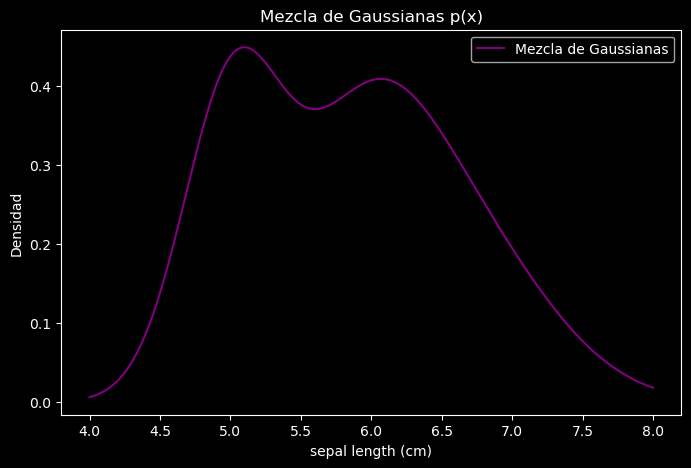

In [71]:
# Mezcla de Gaussianas: p(x) = sum_k p(x|y=k) * p(y=k)
mixture_pdf = pdf_setosa * py[0] + pdf_versicolor * py[1] + pdf_virginica * py[2]

plt.figure(figsize=(8, 5))
plt.plot(x, mixture_pdf, label='Mezcla de Gaussianas', color='purple')
plt.xlabel('sepal length (cm)')
plt.ylabel('Densidad')
plt.title('Mezcla de Gaussianas p(x)')
plt.legend()
plt.show()

Compare esta gráfica con la gráfica de *p(x|y)* usando distribuciones normales.

### Opcional: Aproxime $p(y|x)$ y realice una muestra de 10 valores de $y$ con $x = 4.75$

In [72]:
x_value = 4.75
px_given_y = np.array([kde.evaluate(x_value)[0] for kde in kdes])

# 4. Multiplicar por p(y) y normalizar
unnormalized = px_given_y * py
py_given_x = unnormalized / np.sum(unnormalized)

# 5. Mostrar las probabilidades
for i, prob in enumerate(py_given_x):
    print(f"p(y={class_names[i]} | x={x_value:.2f}) = {prob:.4f}")

# 6. Muestrear 10 valores de y según la distribución obtenida
samples = np.random.choice(class_names, size=10, p=py_given_x)
print("\nMuestra de 10 valores de y dado x=4.75:")
print(samples)


p(y=setosa | x=4.75) = 0.8761
p(y=versicolor | x=4.75) = 0.0960
p(y=virginica | x=4.75) = 0.0278

Muestra de 10 valores de y dado x=4.75:
['setosa' 'versicolor' 'setosa' 'setosa' 'setosa' 'setosa' 'setosa'
 'setosa' 'setosa' 'setosa']
